In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadahmedansari/urdu-dataset-20000")

print("Path to dataset files:", path)

100%|██████████| 3.95G/3.95G [00:46<00:00, 91.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadahmedansari/urdu-dataset-20000/versions/4


In [2]:

# ============================================================================
# CELL 2: Explore Dataset Structure
# ============================================================================
import pandas as pd
import os

# List all files in the downloaded path
print("Files in dataset directory:")
for file in os.listdir(path):
    print(f"  - {file}")

# Find and load TSV files
tsv_files = [f for f in os.listdir(path) if f.endswith('.tsv')]
print(f"\nFound {len(tsv_files)} TSV file(s): {tsv_files}")

# Load the first TSV file
if tsv_files:
    df = pd.read_csv(os.path.join(path, tsv_files[0]), sep='\t')

    print(f"\n{'='*70}")
    print("DATASET OVERVIEW")
    print(f"{'='*70}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumn names:")
    for i, col in enumerate(df.columns):
        print(f"  {i}: {col}")

    print(f"\n{'='*70}")
    print("FIRST 5 ROWS")
    print(f"{'='*70}")
    print(df.head())

    print(f"\n{'='*70}")
    print("DATA TYPES")
    print(f"{'='*70}")
    print(df.dtypes)

    print(f"\n{'='*70}")
    print("MISSING VALUES")
    print(f"{'='*70}")
    print(df.isnull().sum())

    print(f"\n{'='*70}")
    print("SAMPLE DATA (Random 3 rows)")
    print(f"{'='*70}")
    print(df.sample(3))

    print(f"\n{'='*70}")
    print("BASIC STATISTICS")
    print(f"{'='*70}")
    if df.select_dtypes(include=['object']).shape[1] > 0:
        text_col = df.select_dtypes(include=['object']).columns[0]
        print(f"\nText column: '{text_col}'")
        print(f"Sample text: {df[text_col].iloc[0]}")
        print(f"\nText lengths (characters):")
        text_lengths = df[text_col].astype(str).str.len()
        print(f"  Min: {text_lengths.min()}")
        print(f"  Max: {text_lengths.max()}")
        print(f"  Mean: {text_lengths.mean():.2f}")
        print(f"  Median: {text_lengths.median():.2f}")
else:
    print("No TSV files found!")



Files in dataset directory:
  - char_to_num_vocab.pkl
  - model_checkpoint_v2.h5
  - limited_wav_files
  - final_main_dataset.tsv

Found 1 TSV file(s): ['final_main_dataset.tsv']

DATASET OVERVIEW
Shape: 20000 rows × 11 columns

Column names:
  0: client_id
  1: path
  2: sentence
  3: up_votes
  4: down_votes
  5: age
  6: gender
  7: accents
  8: variant
  9: locale
  10: segment

FIRST 5 ROWS
                                           client_id  \
0  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
1  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
2  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
3  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
4  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   

                           path  \
0  common_voice_ur_31771683.mp3   
1  common_voice_ur_31771684.mp3   
2  common_voice_ur_31771685.mp3   
3  common_voice_ur_31771730.mp3   
4  common_voice_ur_31771732.mp3   

                                            sentence 

In [3]:
# ============================================================================
# CELL 3: Import Required Libraries
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ============================================================================
# CELL 4: Urdu Text Preprocessing Functions
# ============================================================================
import unicodedata

def normalize_urdu_text(text):
    """Normalize Urdu text: remove diacritics, standardize Alef and Yeh"""
    if not isinstance(text, str):
        return ""

    # Remove diacritics
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')

    # Standardize Alef forms
    alef_forms = ['آ', 'أ', 'إ', 'ا']
    for alef in alef_forms:
        text = text.replace(alef, 'ا')

    # Standardize Yeh forms
    yeh_forms = ['ی', 'ي', 'ے']
    for yeh in yeh_forms:
        text = text.replace(yeh, 'ی')

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize_urdu(text):
    """Simple word-level tokenization for Urdu"""
    text = normalize_urdu_text(text)
    tokens = re.findall(r'\S+', text)
    return tokens

# Test the functions
print("Testing preprocessing functions:")
test_text = "یہ ایک ٹیسٹ جملہ ہے۔"
print(f"Original: {test_text}")
print(f"Normalized: {normalize_urdu_text(test_text)}")
print(f"Tokens: {tokenize_urdu(test_text)}")


Testing preprocessing functions:
Original: یہ ایک ٹیسٹ جملہ ہے۔
Normalized: یہ ایک ٹیسٹ جملہ ہی۔
Tokens: ['یہ', 'ایک', 'ٹیسٹ', 'جملہ', 'ہی۔']


In [5]:
# ============================================================================
# CELL 5: BALANCED - Conversational Pairs (Quantity + Quality)
# ============================================================================

def has_question_marker(text):
    """Check for question mark"""
    return '؟' in text

def has_question_words(text):
    """Check for Urdu question words"""
    question_words = ['کیا', 'کیوں', 'کب', 'کہاں', 'کون', 'کیسے', 'کتنا', 'کتنی', 'کس', 'کونسا']
    tokens = tokenize_urdu(text)
    return any(word in tokens for word in question_words)

def is_question(text):
    """Question detection"""
    return has_question_marker(text) or has_question_words(text)

def calculate_semantic_relatedness(text1, text2):
    """Calculate word overlap between texts"""
    words1 = set(tokenize_urdu(text1))
    words2 = set(tokenize_urdu(text2))

    # Remove common stop words
    stop_words = {'کی', 'میں', 'ہی', 'کا', 'سی', 'کو', 'اور', 'اس', 'یہ', 'نی', 'پر', 'تو', 'بھی', 'ہیں', 'ایک', 'وہ'}
    words1 = words1 - stop_words
    words2 = words2 - stop_words

    if len(words1) == 0 or len(words2) == 0:
        return 0.0

    intersection = len(words1 & words2)
    union = len(words1 | words2)

    return intersection / union if union > 0 else 0.0

def create_balanced_pairs(df, target_pairs=10000):
    """
    Create conversational pairs with BALANCED quality vs quantity
    Target: Get at least 10,000 pairs
    """
    all_pairs = []

    print("="*70)
    print("MULTI-STRATEGY PAIR CREATION")
    print(f"Target: {target_pairs} pairs")
    print("="*70)

    # ========================================================================
    # STRATEGY 1: Question-Answer (HIGHEST QUALITY)
    # ========================================================================
    print("\n[1/5] Question-Answer pairs...")
    qa_pairs = []

    for i in range(len(df) - 1):
        input_text = str(df.iloc[i]['sentence']).strip()
        response_text = str(df.iloc[i+1]['sentence']).strip()

        if is_question(input_text):
            if (10 < len(input_text) < 150 and 10 < len(response_text) < 150):
                relatedness = calculate_semantic_relatedness(input_text, response_text)
                qa_pairs.append({
                    'input': input_text,
                    'response': response_text,
                    'type': 'question-answer',
                    'quality': 'high',
                    'relatedness': relatedness
                })

    print(f"  ✓ Found {len(qa_pairs)} question-answer pairs")
    all_pairs.extend(qa_pairs)

    # ========================================================================
    # STRATEGY 2: High-Overlap Adjacent Sentences (HIGH QUALITY)
    # ========================================================================
    print("\n[2/5] High-overlap adjacent pairs...")
    high_overlap_pairs = []

    for i in range(len(df) - 1):
        input_text = str(df.iloc[i]['sentence']).strip()
        response_text = str(df.iloc[i+1]['sentence']).strip()

        if (15 < len(input_text) < 150 and 15 < len(response_text) < 150):
            relatedness = calculate_semantic_relatedness(input_text, response_text)

            if relatedness >= 0.1:  # At least 10% overlap
                high_overlap_pairs.append({
                    'input': input_text,
                    'response': response_text,
                    'type': 'high-overlap',
                    'quality': 'high',
                    'relatedness': relatedness
                })

    print(f"  ✓ Found {len(high_overlap_pairs)} high-overlap pairs")
    all_pairs.extend(high_overlap_pairs)

    # ========================================================================
    # STRATEGY 3: Context-Response (2 sentences → 1)
    # ========================================================================
    print("\n[3/5] Context-response pairs...")
    context_pairs = []

    for i in range(len(df) - 2):
        context = str(df.iloc[i]['sentence']).strip() + ' ' + str(df.iloc[i+1]['sentence']).strip()
        response = str(df.iloc[i+2]['sentence']).strip()

        if (20 < len(context) < 200 and 15 < len(response) < 150):
            relatedness = calculate_semantic_relatedness(context, response)

            if relatedness >= 0.05:  # Lowered threshold
                context_pairs.append({
                    'input': context,
                    'response': response,
                    'type': 'context-response',
                    'quality': 'medium',
                    'relatedness': relatedness
                })

    print(f"  ✓ Found {len(context_pairs)} context-response pairs")
    all_pairs.extend(context_pairs)

    # ========================================================================
    # STRATEGY 4: Topic Continuation (LOW THRESHOLD)
    # ========================================================================
    print("\n[4/5] Topic continuation pairs...")
    continuation_pairs = []

    for i in range(len(df) - 1):
        input_text = str(df.iloc[i]['sentence']).strip()
        response_text = str(df.iloc[i+1]['sentence']).strip()

        # Accept if reasonable length
        if (10 < len(input_text) < 150 and 10 < len(response_text) < 150):
            relatedness = calculate_semantic_relatedness(input_text, response_text)

            # Very low threshold - just checking both are valid Urdu
            if len(tokenize_urdu(input_text)) >= 3 and len(tokenize_urdu(response_text)) >= 3:
                continuation_pairs.append({
                    'input': input_text,
                    'response': response_text,
                    'type': 'continuation',
                    'quality': 'medium',
                    'relatedness': relatedness
                })

    print(f"  ✓ Found {len(continuation_pairs)} continuation pairs")
    all_pairs.extend(continuation_pairs)

    # ========================================================================
    # STRATEGY 5: Sentence Splitting (CREATE MORE DATA)
    # ========================================================================
    print("\n[5/5] Sentence splitting for augmentation...")
    split_pairs = []

    for i in range(len(df)):
        text = str(df.iloc[i]['sentence']).strip()

        # Split long sentences at punctuation
        if len(text) > 100:
            # Try to split at common punctuation
            for punct in ['،', '۔', '؛']:
                if punct in text:
                    parts = text.split(punct)
                    for j in range(len(parts) - 1):
                        part1 = parts[j].strip()
                        part2 = parts[j+1].strip()

                        if (10 < len(part1) < 100 and 10 < len(part2) < 100):
                            relatedness = calculate_semantic_relatedness(part1, part2)
                            split_pairs.append({
                                'input': part1,
                                'response': part2,
                                'type': 'split',
                                'quality': 'medium',
                                'relatedness': relatedness
                            })
                    break

    print(f"  ✓ Created {len(split_pairs)} split pairs")
    all_pairs.extend(split_pairs)

    # ========================================================================
    # REMOVE DUPLICATES
    # ========================================================================
    print(f"\n{'='*70}")
    print("DEDUPLICATION")
    print(f"{'='*70}")

    print(f"Before deduplication: {len(all_pairs)} pairs")

    # Remove exact duplicates
    seen = set()
    unique_pairs = []
    for pair in all_pairs:
        key = (pair['input'], pair['response'])
        if key not in seen:
            seen.add(key)
            unique_pairs.append(pair)

    print(f"After deduplication:  {len(unique_pairs)} pairs")

    # ========================================================================
    # SUMMARY
    # ========================================================================
    print(f"\n{'='*70}")
    print("FINAL DATASET SUMMARY")
    print(f"{'='*70}")

    df_pairs = pd.DataFrame(unique_pairs)

    print(f"\nTotal pairs: {len(df_pairs)}")
    print(f"\nBreakdown by type:")
    print(df_pairs['type'].value_counts())

    print(f"\nBreakdown by quality:")
    print(df_pairs['quality'].value_counts())

    print(f"\nRelatedness statistics:")
    print(f"  Min:    {df_pairs['relatedness'].min():.4f}")
    print(f"  Max:    {df_pairs['relatedness'].max():.4f}")
    print(f"  Mean:   {df_pairs['relatedness'].mean():.4f}")
    print(f"  Median: {df_pairs['relatedness'].median():.4f}")

    # Show sample from each type
    print(f"\n{'='*70}")
    print("SAMPLES FROM EACH TYPE")
    print(f"{'='*70}")

    for pair_type in df_pairs['type'].unique():
        samples = df_pairs[df_pairs['type'] == pair_type].nlargest(2, 'relatedness')
        print(f"\n--- {pair_type.upper()} ---")
        for _, row in samples.iterrows():
            print(f"Input:    {row['input'][:80]}...")
            print(f"Response: {row['response'][:80]}...")
            print(f"Relatedness: {row['relatedness']:.3f}\n")

    return df_pairs

# ============================================================================
# CREATE DATASET
# ============================================================================

print("\n" + "="*70)
print("CREATING BALANCED CONVERSATIONAL DATASET")
print("="*70)

pairs_df = create_balanced_pairs(df, target_pairs=10000)

# Keep only necessary columns
text_data = pairs_df[['input', 'response']]

print(f"\n{'='*70}")
print(f"✓ Dataset ready with {len(text_data)} conversational pairs!")
print(f"{'='*70}")

# Check if we have enough data
if len(text_data) < 5000:
    print(f"\n⚠️  WARNING: Only {len(text_data)} pairs found.")
    print("This is below the recommended 5,000 minimum.")
    print("Training will proceed but results may be limited.")
    print("\nSuggestion: Consider using a larger Urdu corpus or different dataset.")
elif len(text_data) < 10000:
    print(f"\n⚠️  Note: {len(text_data)} pairs is acceptable but more data would be better.")
else:
    print(f"\n✓ Good: {len(text_data)} pairs is sufficient for training!")


CREATING BALANCED CONVERSATIONAL DATASET
MULTI-STRATEGY PAIR CREATION
Target: 10000 pairs

[1/5] Question-Answer pairs...
  ✓ Found 1837 question-answer pairs

[2/5] High-overlap adjacent pairs...
  ✓ Found 398 high-overlap pairs

[3/5] Context-response pairs...
  ✓ Found 1740 context-response pairs

[4/5] Topic continuation pairs...
  ✓ Found 18715 continuation pairs

[5/5] Sentence splitting for augmentation...
  ✓ Created 3 split pairs

DEDUPLICATION
Before deduplication: 22693 pairs
After deduplication:  17017 pairs

FINAL DATASET SUMMARY

Total pairs: 17017

Breakdown by type:
type
continuation        13701
question-answer      1530
context-response     1495
high-overlap          288
split                   3
Name: count, dtype: int64

Breakdown by quality:
quality
medium    15199
high       1818
Name: count, dtype: int64

Relatedness statistics:
  Min:    0.0000
  Max:    0.7000
  Mean:   0.0123
  Median: 0.0000

SAMPLES FROM EACH TYPE

--- QUESTION-ANSWER ---
Input:    ہم اور ک

In [6]:
# ============================================================================
# CELL 6: Build Vocabulary (Updated for Conversational Pairs)
# ============================================================================
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.word_count = {}
        self.n_words = 4

    def add_sentence(self, sentence):
        for word in tokenize_urdu(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

vocab = Vocabulary()
print("Building vocabulary from conversational pairs...")
print(f"Processing {len(text_data)} pairs...")

# Process both input and response from each pair
for _, row in tqdm(text_data.iterrows(), desc="Processing sentences", total=len(text_data)):
    vocab.add_sentence(str(row['input']))
    vocab.add_sentence(str(row['response']))

print(f"\n{'='*70}")
print("VOCABULARY STATISTICS")
print(f"{'='*70}")
print(f"Total vocabulary size: {vocab.n_words}")
print(f"Total unique words (excluding special tokens): {vocab.n_words - 4}")

print(f"\n{'='*70}")
print("MOST COMMON WORDS")
print(f"{'='*70}")
common_words = sorted(vocab.word_count.items(), key=lambda x: x[1], reverse=True)[:20]
for i, (word, count) in enumerate(common_words, 1):
    print(f"{i:2}. {word:20} → {count:5} occurrences")

print(f"\n{'='*70}")
print("SPECIAL TOKENS")
print(f"{'='*70}")
for token, idx in vocab.word2idx.items():
    if idx < 4:
        print(f"  {token:10} → Index: {idx}")

print(f"\n{'='*70}")
print("VOCABULARY COVERAGE")
print(f"{'='*70}")
total_words = sum(vocab.word_count.values())
print(f"Total word occurrences: {total_words:,}")

# Calculate coverage of most common words
cumulative_count = 0
for i, (word, count) in enumerate(common_words, 1):
    cumulative_count += count
    coverage = (cumulative_count / total_words) * 100
    if i in [10, 50, 100, 500]:
        print(f"Top {i:4} words cover: {coverage:.2f}% of all words")
    if i == len(common_words):
        print(f"Top {i:4} words cover: {coverage:.2f}% of all words")

print(f"\n{'='*70}")
print("✓ Vocabulary built successfully!")
print(f"{'='*70}")

Building vocabulary from conversational pairs...
Processing 17017 pairs...


Processing sentences: 100%|██████████| 17017/17017 [00:03<00:00, 5224.67it/s]


VOCABULARY STATISTICS
Total vocabulary size: 10647
Total unique words (excluding special tokens): 10643

MOST COMMON WORDS
 1. کی                   → 15206 occurrences
 2. میں                  →  7616 occurrences
 3. ہی                   →  6302 occurrences
 4. کا                   →  5936 occurrences
 5. ہی۔                  →  5528 occurrences
 6. سی                   →  5475 occurrences
 7. کو                   →  3760 occurrences
 8. اس                   →  3483 occurrences
 9. اور                  →  3417 occurrences
10. یہ                   →  3148 occurrences
11. نہیں                 →  2813 occurrences
12. تو                   →  2572 occurrences
13. نی                   →  2491 occurrences
14. بھی                  →  2425 occurrences
15. پر                   →  2398 occurrences
16. کیا                  →  2237 occurrences
17. ہیں۔                 →  2229 occurrences
18. ایک                  →  2154 occurrences
19. ہیں                  →  2065 occurrences
20. وہ               

In [7]:
# ============================================================================
# CELL 6B: OPTIMIZED - Span Corruption with Quality-Aware Augmentation
# ============================================================================

import random

class OptimizedSpanCorruption:
    """
    Span corruption that prioritizes high-quality pairs
    """
    def __init__(self, vocab, corruption_rate=0.15, mean_span_length=3):
        self.vocab = vocab
        self.corruption_rate = corruption_rate
        self.mean_span_length = mean_span_length
        self.sentinel_tokens = {}

        # Add sentinel tokens
        for i in range(100):
            sentinel = f'<SENTINEL_{i}>'
            if sentinel not in vocab.word2idx:
                vocab.word2idx[sentinel] = vocab.n_words
                vocab.idx2word[vocab.n_words] = sentinel
                vocab.n_words += 1
                self.sentinel_tokens[i] = vocab.n_words - 1

    def corrupt_spans(self, text):
        """Apply span corruption"""
        tokens = tokenize_urdu(text)

        if len(tokens) < 5:
            return None, None

        # Calculate spans to corrupt
        num_to_corrupt = max(1, int(len(tokens) * self.corruption_rate))

        # Randomly select span starting positions
        available_positions = list(range(len(tokens) - 1))
        random.shuffle(available_positions)

        corrupted_spans = []
        tokens_to_corrupt = set()
        sentinel_id = 0

        for start in available_positions:
            if len(tokens_to_corrupt) >= num_to_corrupt:
                break

            if start in tokens_to_corrupt:
                continue

            # Determine span length
            span_length = min(
                np.random.geometric(1.0 / self.mean_span_length),
                len(tokens) - start,
                4  # Max span
            )

            span_indices = list(range(start, min(start + span_length, len(tokens))))

            if not any(idx in tokens_to_corrupt for idx in span_indices):
                corrupted_spans.append((start, span_indices, sentinel_id))
                tokens_to_corrupt.update(span_indices)
                sentinel_id += 1

        if not corrupted_spans:
            return None, None

        # Sort spans by position
        corrupted_spans.sort(key=lambda x: x[0])

        # Build corrupted input and target
        corrupted_input = []
        target_output = []

        last_idx = 0
        for start, span_indices, sent_id in corrupted_spans:
            corrupted_input.extend(tokens[last_idx:start])
            sentinel = f'<SENTINEL_{sent_id}>'
            corrupted_input.append(sentinel)
            target_output.append(sentinel)
            target_output.extend([tokens[i] for i in span_indices])
            last_idx = span_indices[-1] + 1

        corrupted_input.extend(tokens[last_idx:])

        if len(corrupted_input) < 3 or len(target_output) < 2:
            return None, None

        return ' '.join(corrupted_input), ' '.join(target_output)

    def augment_dataset(self, pairs_df, augmentation_ratio=0.2):
        """
        Augment dataset with focus on high-quality pairs
        """
        augmented_pairs = []

        # Keep all original pairs
        print("Preserving all original pairs...")
        for _, row in pairs_df.iterrows():
            augmented_pairs.append({
                'input': row['input'],
                'response': row['response']
            })

        print(f"Original pairs preserved: {len(pairs_df)}")

        # Separate by quality if available
        if 'quality' in pairs_df.columns:
            high_quality = pairs_df[pairs_df['quality'] == 'high']
            medium_quality = pairs_df[pairs_df['quality'] == 'medium']

            # Augment MORE high-quality pairs (40%)
            num_high = int(len(high_quality) * 0.4)
            # Augment FEWER medium-quality pairs (15%)
            num_medium = int(len(medium_quality) * 0.15)

            samples_to_corrupt = pd.concat([
                high_quality.sample(n=min(num_high, len(high_quality)), random_state=42),
                medium_quality.sample(n=min(num_medium, len(medium_quality)), random_state=42)
            ])

            print(f"\nQuality-aware augmentation:")
            print(f"  High-quality pairs to augment: {min(num_high, len(high_quality))}")
            print(f"  Medium-quality pairs to augment: {min(num_medium, len(medium_quality))}")
        else:
            # Fallback: uniform sampling
            num_to_augment = int(len(pairs_df) * augmentation_ratio)
            samples_to_corrupt = pairs_df.sample(n=min(num_to_augment, len(pairs_df)), random_state=42)
            print(f"\nUniform augmentation: {len(samples_to_corrupt)} pairs")

        print(f"\nTotal pairs to corrupt: {len(samples_to_corrupt)}")
        print("Applying span corruption...")

        successful_corruptions = 0

        for _, row in tqdm(samples_to_corrupt.iterrows(), desc="Corrupting", total=len(samples_to_corrupt)):
            # Corrupt the input
            corrupted_input, corruption_target = self.corrupt_spans(row['input'])

            if corrupted_input and corruption_target:
                # Denoising task: corrupted input → original input
                augmented_pairs.append({
                    'input': corrupted_input,
                    'response': row['input']  # Reconstruct original
                })
                successful_corruptions += 1

        print(f"✓ Successfully created {successful_corruptions} corrupted pairs")

        return pd.DataFrame(augmented_pairs)

# ============================================================================
# RUN SPAN CORRUPTION
# ============================================================================

print("="*70)
print("QUALITY-AWARE SPAN CORRUPTION AUGMENTATION")
print("="*70)

span_corruptor = OptimizedSpanCorruption(vocab, corruption_rate=0.15, mean_span_length=3)

print(f"\nDataset statistics:")
print(f"  Original pairs: {len(text_data)}")
print(f"  Vocabulary before sentinels: {vocab.n_words - 100}")
print(f"  Vocabulary after sentinels: {vocab.n_words}")

# Check if we have quality information
if 'quality' in pairs_df.columns:
    # Pass the full dataframe with quality info
    text_data_augmented = span_corruptor.augment_dataset(pairs_df, augmentation_ratio=0.2)
else:
    # Fallback without quality info
    text_data_augmented = span_corruptor.augment_dataset(text_data, augmentation_ratio=0.2)

print(f"\n{'='*70}")
print("AUGMENTATION RESULTS")
print(f"{'='*70}")
print(f"Original pairs:   {len(text_data)}")
print(f"Augmented pairs:  {len(text_data_augmented)}")
print(f"New pairs added:  +{len(text_data_augmented) - len(text_data)}")
print(f"Increase:         {((len(text_data_augmented) / len(text_data)) - 1) * 100:.1f}%")

# Show examples
print(f"\n{'='*70}")
print("SPAN CORRUPTION EXAMPLES")
print(f"{'='*70}")

corrupted_samples = text_data_augmented[text_data_augmented['input'].str.contains('SENTINEL', na=False)].head(5)

for i, (idx, row) in enumerate(corrupted_samples.iterrows(), 1):
    print(f"\n--- Example {i} ---")
    print(f"Corrupted:  {row['input'][:100]}...")
    print(f"Target:     {row['response'][:100]}...")

# Keep only input and response columns
text_data = text_data_augmented[['input', 'response']]

print(f"\n{'='*70}")
print(f"✓ Final dataset ready: {len(text_data)} pairs")
print(f"{'='*70}")

# Final statistics
print(f"\nFinal Training Data:")
print(f"  Total pairs: {len(text_data):,}")
print(f"  Expected train set (80%): ~{int(len(text_data) * 0.8):,}")
print(f"  Expected val set (10%): ~{int(len(text_data) * 0.1):,}")
print(f"  Expected test set (10%): ~{int(len(text_data) * 0.1):,}")


QUALITY-AWARE SPAN CORRUPTION AUGMENTATION

Dataset statistics:
  Original pairs: 17017
  Vocabulary before sentinels: 10647
  Vocabulary after sentinels: 10747
Preserving all original pairs...
Original pairs preserved: 17017

Quality-aware augmentation:
  High-quality pairs to augment: 727
  Medium-quality pairs to augment: 2279

Total pairs to corrupt: 3006
Applying span corruption...


Corrupting: 100%|██████████| 3006/3006 [00:00<00:00, 13142.27it/s]

✓ Successfully created 2542 corrupted pairs

AUGMENTATION RESULTS
Original pairs:   17017
Augmented pairs:  19559
New pairs added:  +2542
Increase:         14.9%

SPAN CORRUPTION EXAMPLES

--- Example 1 ---
Corrupted:  وہ یہ <SENTINEL_0> ایشوریا نی جو بھی...
Target:     وہ یہ ہے کہ ایشوریا نے جو بھی...

--- Example 2 ---
Corrupted:  اک بار ہی جی <SENTINEL_0> نہیں دیتی...
Target:     اک بار ہی جی بھر کے سزا کیوں نہیں دیتے...

--- Example 3 ---
Corrupted:  <SENTINEL_0> چیزوں کا خیال نہیں ایا؟...
Target:     تب انہیں ان چیزوں کا خیال نہیں آیا؟...

--- Example 4 ---
Corrupted:  کیا وہ بھی <SENTINEL_0> نیک مقصد کی لیی حوالہ زنداں ہیں؟...
Target:     کیا وہ بھی کسی نیک مقصد کے لیے حوالۂ زنداں ہیں؟...

--- Example 5 ---
Corrupted:  تو پھر کپتان کوئی <SENTINEL_0> ہو...
Target:     تو پھر کپتان کوئی بھی ہو...

✓ Final dataset ready: 19559 pairs

Final Training Data:
  Total pairs: 19,559
  Expected train set (80%): ~15,647
  Expected val set (10%): ~1,955
  Expected test set (10%): ~1,955


In [8]:
# ============================================================================
# CELL 7: Dataset Split (80% Train, 10% Val, 10% Test)
# ============================================================================

print("="*70)
print("SPLITTING CONVERSATIONAL PAIRS")
print("="*70)

# text_data is already a DataFrame with 'input' and 'response' columns
print(f"Total conversational pairs: {len(text_data)}")

# Split: 80% train, 10% validation, 10% test
train_data, temp_data = train_test_split(text_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"\n{'='*70}")
print("SPLIT STATISTICS")
print(f"{'='*70}")
print(f"Training samples:   {len(train_data):5} ({len(train_data)/len(text_data)*100:.1f}%)")
print(f"Validation samples: {len(val_data):5} ({len(val_data)/len(text_data)*100:.1f}%)")
print(f"Test samples:       {len(test_data):5} ({len(test_data)/len(text_data)*100:.1f}%)")

print(f"\n{'='*70}")
print("SAMPLE FROM EACH SPLIT")
print(f"{'='*70}")

print("\n--- TRAINING SET (Sample 1) ---")
sample_train = train_data.iloc[0]
print(f"Input:    {sample_train['input']}")
print(f"Response: {sample_train['response']}")

print("\n--- VALIDATION SET (Sample 1) ---")
sample_val = val_data.iloc[0]
print(f"Input:    {sample_val['input']}")
print(f"Response: {sample_val['response']}")

print("\n--- TEST SET (Sample 1) ---")
sample_test = test_data.iloc[0]
print(f"Input:    {sample_test['input']}")
print(f"Response: {sample_test['response']}")

print(f"\n{'='*70}")
print("✓ Dataset split completed successfully!")
print(f"{'='*70}")

SPLITTING CONVERSATIONAL PAIRS
Total conversational pairs: 19559

SPLIT STATISTICS
Training samples:   15647 (80.0%)
Validation samples:  1956 (10.0%)
Test samples:        1956 (10.0%)

SAMPLE FROM EACH SPLIT

--- TRAINING SET (Sample 1) ---
Input:    بجلی نہیں چمکتی تو <SENTINEL_0>
Response: بجلی نہیں چمکتی تو رک جاتا ہے۔

--- VALIDATION SET (Sample 1) ---
Input:    انہیں یہ بات سمجھنی چاہیے کہ لیڈر وژن سے بنتا ہے۔
Response: اس طرح کی اور بھی فلمیں ہونی چاہئے

--- TEST SET (Sample 1) ---
Input:    جیسے پہلے تھے۔
Response: بہت روتے ہیں۔

✓ Dataset split completed successfully!


In [9]:
# ============================================================================
# CELL 8: PyTorch Dataset Class (Updated for Conversational Pairs)
# ============================================================================
class UrduConversationalDataset(Dataset):
    """
    Dataset for Urdu conversational pairs (input -> response)
    Encoder receives input, Decoder generates response
    """
    def __init__(self, dataframe, vocab, max_len=50):
        self.data = dataframe.reset_index(drop=True)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def tokenize_and_encode(self, text, add_sos=False, add_eos=False):
        """Tokenize text and convert to indices"""
        tokens = tokenize_urdu(text)

        # Convert to indices
        indices = [self.vocab.word2idx.get(token, self.vocab.word2idx['<UNK>'])
                   for token in tokens]

        # Add special tokens
        if add_sos:
            indices = [self.vocab.word2idx['<SOS>']] + indices
        if add_eos:
            indices = indices + [self.vocab.word2idx['<EOS>']]

        # Pad or truncate
        if len(indices) < self.max_len:
            indices += [self.vocab.word2idx['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]

        return indices

    def __getitem__(self, idx):
        # Get input and response texts
        input_text = str(self.data.iloc[idx]['input'])
        response_text = str(self.data.iloc[idx]['response'])

        # Encoder input: Add SOS and EOS to input
        encoder_input = self.tokenize_and_encode(input_text, add_sos=True, add_eos=True)

        # Decoder input: Add SOS to response (used during training with teacher forcing)
        decoder_input = self.tokenize_and_encode(response_text, add_sos=True, add_eos=False)

        # Decoder target: Add EOS to response (what decoder should predict)
        decoder_target = self.tokenize_and_encode(response_text, add_sos=False, add_eos=True)

        return {
            'encoder_input': torch.tensor(encoder_input, dtype=torch.long),
            'decoder_input': torch.tensor(decoder_input, dtype=torch.long),
            'decoder_target': torch.tensor(decoder_target, dtype=torch.long)
        }

# Create datasets
train_dataset = UrduConversationalDataset(train_data, vocab, max_len=50)
val_dataset = UrduConversationalDataset(val_data, vocab, max_len=50)
test_dataset = UrduConversationalDataset(test_data, vocab, max_len=50)

print("="*70)
print("DATASETS CREATED SUCCESSFULLY")
print("="*70)
print(f"Training dataset:   {len(train_dataset):5} pairs")
print(f"Validation dataset: {len(val_dataset):5} pairs")
print(f"Test dataset:       {len(test_dataset):5} pairs")

print(f"\n{'='*70}")
print("SAMPLE DATA POINT (Index 0)")
print(f"{'='*70}")

sample = train_dataset[0]
print(f"\nEncoder Input shape:  {sample['encoder_input'].shape}")
print(f"Decoder Input shape:  {sample['decoder_input'].shape}")
print(f"Decoder Target shape: {sample['decoder_target'].shape}")

# Decode and show the actual text
print(f"\n{'='*70}")
print("DECODED SAMPLE")
print(f"{'='*70}")

def decode_indices(indices, vocab):
    """Convert indices back to text"""
    words = []
    for idx in indices:
        idx = idx.item() if torch.is_tensor(idx) else idx
        if idx == vocab.word2idx['<PAD>']:
            break
        word = vocab.idx2word[idx]
        if word not in ['<SOS>', '<EOS>', '<PAD>']:
            words.append(word)
    return ' '.join(words)

encoder_text = decode_indices(sample['encoder_input'], vocab)
decoder_input_text = decode_indices(sample['decoder_input'], vocab)
decoder_target_text = decode_indices(sample['decoder_target'], vocab)

print(f"\nOriginal Input:   {train_data.iloc[0]['input']}")
print(f"Encoded Input:    {encoder_text}")
print(f"\nOriginal Response: {train_data.iloc[0]['response']}")
print(f"Decoder Input:     {decoder_input_text}")
print(f"Decoder Target:    {decoder_target_text}")

print(f"\n{'='*70}")
print("TOKEN SEQUENCES (First 15 tokens)")
print(f"{'='*70}")
print(f"Encoder Input:  {sample['encoder_input'][:15].tolist()}")
print(f"Decoder Input:  {sample['decoder_input'][:15].tolist()}")
print(f"Decoder Target: {sample['decoder_target'][:15].tolist()}")

print(f"\n{'='*70}")
print("✓ Dataset class updated for conversational pairs!")
print(f"{'='*70}")

DATASETS CREATED SUCCESSFULLY
Training dataset:   15647 pairs
Validation dataset:  1956 pairs
Test dataset:        1956 pairs

SAMPLE DATA POINT (Index 0)

Encoder Input shape:  torch.Size([50])
Decoder Input shape:  torch.Size([50])
Decoder Target shape: torch.Size([50])

DECODED SAMPLE

Original Input:   بجلی نہیں چمکتی تو <SENTINEL_0>
Encoded Input:    بجلی نہیں چمکتی تو <SENTINEL_0>

Original Response: بجلی نہیں چمکتی تو رک جاتا ہے۔
Decoder Input:     بجلی نہیں چمکتی تو رک جاتا ہی۔
Decoder Target:    بجلی نہیں چمکتی تو رک جاتا ہی۔

TOKEN SEQUENCES (First 15 tokens)
Encoder Input:  [1, 1791, 61, 4739, 138, 10647, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Decoder Input:  [1, 1791, 61, 4739, 138, 4617, 1140, 36, 0, 0, 0, 0, 0, 0, 0]
Decoder Target: [1791, 61, 4739, 138, 4617, 1140, 36, 2, 0, 0, 0, 0, 0, 0, 0]

✓ Dataset class updated for conversational pairs!


In [ ]:
# ============================================================================
# CELL 9: Positional Encoding
# ============================================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

#comment
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

print("Positional Encoding defined!")


Positional Encoding defined!


In [ ]:
# ============================================================================
# CELL 10: Transformer Encoder Layer
# ============================================================================
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.self_attn(x, x, x, key_padding_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

print("Transformer Encoder Layer defined!")


Transformer Encoder Layer defined!


In [ ]:
# ============================================================================
# CELL 11: Transformer Decoder Layer
# ============================================================================
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, tgt_mask=None, src_mask=None):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        attn_output, _ = self.cross_attn(x, encoder_output, encoder_output, key_padding_mask=src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x

print("Transformer Decoder Layer defined!")


Transformer Decoder Layer defined!


In [ ]:
# ============================================================================
# CELL 12: Complete Transformer Model
# ============================================================================
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=2, n_encoder_layers=2,
                 n_decoder_layers=2, d_ff=512, dropout=0.1, max_len=50):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])

        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, src, tgt):
        src_mask = (src == 0)  
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        src_emb = self.dropout(self.pos_encoding(self.embedding(src) * math.sqrt(self.d_model)))
        encoder_output = src_emb
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output, src_mask)

        tgt_emb = self.dropout(self.pos_encoding(self.embedding(tgt) * math.sqrt(self.d_model)))
        decoder_output = tgt_emb
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output, tgt_mask, src_mask)

        output = self.fc_out(decoder_output)
        return output

print("Transformer model defined successfully!")



Transformer model defined successfully!


In [ ]:
# ============================================================================
# CELL 13: OPTIMIZED TRAINING CONFIGURATION (~20K PAIRS) - FIXED
# ============================================================================

print("="*70)
print("OPTIMIZED TRAINING CONFIGURATION")
print("="*70)

# Hyperparameters optimized for your dataset size
BATCH_SIZE = 32
LEARNING_RATE = 2e-4  # Lower for stability
NUM_EPOCHS = 35       # More epochs since we have good data
D_MODEL = 384         # Medium size (good balance)
N_HEADS = 2           # Must divide D_MODEL evenly (384/6=64)
N_ENCODER_LAYERS = 2
N_DECODER_LAYERS = 2
DROPOUT = 0.2
MAX_LEN = 50

print("\nHyperparameters:")
print(f"  Batch Size:        {BATCH_SIZE}")
print(f"  Learning Rate:     {LEARNING_RATE}")
print(f"  Num Epochs:        {NUM_EPOCHS}")
print(f"  Embedding Dim:     {D_MODEL}")
print(f"  Attention Heads:   {N_HEADS}")
print(f"  Encoder Layers:    {N_ENCODER_LAYERS}")
print(f"  Decoder Layers:    {N_DECODER_LAYERS}")
print(f"  Dropout:           {DROPOUT}")
print(f"  Max Sequence Len:  {MAX_LEN}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")

# Initialize model
model = Transformer(
    vocab_size=vocab.n_words,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_encoder_layers=N_ENCODER_LAYERS,
    n_decoder_layers=N_DECODER_LAYERS,
    d_ff=D_MODEL * 4,  # 1536
    dropout=DROPOUT,
    max_len=MAX_LEN
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size (approx):  {total_params * 4 / (1024**2):.2f} MB")

# Loss with label smoothing (helps with generalization)
criterion = nn.CrossEntropyLoss(
    ignore_index=vocab.word2idx['<PAD>'],
    label_smoothing=0.1
)

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.98),
    eps=1e-9
)

# Learning rate scheduler (reduces LR when validation plateaus)
from torch.optim.lr_scheduler import ReduceLROnPlateau

# FIX: Remove 'verbose' parameter
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

print(f"\nOptimizer: Adam with β=(0.9, 0.98)")
print(f"Loss: CrossEntropyLoss with label_smoothing=0.1")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

print(f"\n{'='*70}")
print("✓ Training configuration complete!")
print(f"{'='*70}")

# Quick sanity check
print(f"\nRunning sanity check...")
sample_batch = next(iter(train_loader))
encoder_input = sample_batch['encoder_input'].to(device)
decoder_input = sample_batch['decoder_input'].to(device)

with torch.no_grad():
    output = model(encoder_input, decoder_input)

print(f"✓ Model forward pass successful!")
print(f"  Batch size:     {encoder_input.shape[0]}")
print(f"  Sequence len:   {encoder_input.shape[1]}")
print(f"  Output shape:   {output.shape}")
print(f"  Expected:       [{BATCH_SIZE}, {MAX_LEN}, {vocab.n_words}]")

print(f"\n{'='*70}")
print("Ready to start training!")
print(f"{'='*70}")

OPTIMIZED TRAINING CONFIGURATION

Hyperparameters:
  Batch Size:        32
  Learning Rate:     0.0002
  Num Epochs:        35
  Embedding Dim:     384
  Attention Heads:   6
  Encoder Layers:    2
  Decoder Layers:    2
  Dropout:           0.2
  Max Sequence Len:  50

DataLoaders created:
  Train batches: 489
  Val batches:   62

Model Statistics:
  Total parameters:     16,546,555
  Trainable parameters: 16,546,555
  Model size (approx):  63.12 MB

Optimizer: Adam with β=(0.9, 0.98)
Loss: CrossEntropyLoss with label_smoothing=0.1
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

✓ Training configuration complete!

Running sanity check...
✓ Model forward pass successful!
  Batch size:     32
  Sequence len:   50
  Output shape:   torch.Size([32, 50, 10747])
  Expected:       [32, 50, 10747]

Ready to start training!


In [15]:
# ============================================================================
# CELL 14: Training Functions (Updated for Conversational Dataset)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in tqdm(dataloader, desc="Training"):
        # Extract data from dictionary
        encoder_input = batch['encoder_input'].to(device)
        decoder_input = batch['decoder_input'].to(device)
        decoder_target = batch['decoder_target'].to(device)

        optimizer.zero_grad()

        # Forward pass: encoder gets input, decoder gets response prefix
        output = model(encoder_input, decoder_input)

        # Calculate loss (ignore padding tokens)
        loss = criterion(output.reshape(-1, vocab.n_words), decoder_target.reshape(-1))

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches


def evaluate(model, dataloader, criterion, device):
    """Evaluate on validation/test set"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Extract data from dictionary
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            decoder_target = batch['decoder_target'].to(device)

            # Forward pass
            output = model(encoder_input, decoder_input)

            # Calculate loss
            loss = criterion(output.reshape(-1, vocab.n_words), decoder_target.reshape(-1))

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches


print("="*70)
print("✓ Training functions updated for conversational pairs!")
print("="*70)
print("\nKey changes:")
print("  • Extracts encoder_input, decoder_input, decoder_target from batch dictionary")
print("  • Model receives: model(encoder_input, decoder_input)")
print("  • Loss calculated against: decoder_target")
print("  • Gradient clipping applied to prevent exploding gradients")
print("="*70)

✓ Training functions updated for conversational pairs!

Key changes:
  • Extracts encoder_input, decoder_input, decoder_target from batch dictionary
  • Model receives: model(encoder_input, decoder_input)
  • Loss calculated against: decoder_target
  • Gradient clipping applied to prevent exploding gradients


In [16]:
# ============================================================================
# CELL 15: IMPROVED TRAINING LOOP
# ============================================================================
import time

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Total epochs: {NUM_EPOCHS}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Device: {device}")
print("="*70)

best_val_loss = float('inf')
train_losses = []
val_losses = []
learning_rates = []
epoch_times = []

# Early stopping
patience = 7
patience_counter = 0

training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*70}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss = evaluate(model, val_loader, criterion, device)

    # Step scheduler (reduce LR on plateau)
    scheduler.step(val_loss)

    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Calculate perplexity
    train_ppl = math.exp(min(train_loss, 10))
    val_ppl = math.exp(min(val_loss, 10))

    print(f"\n{'='*70}")
    print("EPOCH RESULTS")
    print(f"{'='*70}")
    print(f"Train Loss:       {train_loss:.4f}")
    print(f"Val Loss:         {val_loss:.4f}")
    print(f"Train Perplexity: {train_ppl:.2f}")
    print(f"Val Perplexity:   {val_ppl:.2f}")
    print(f"Epoch Time:       {epoch_time:.2f}s")

    # Calculate improvement
    if epoch > 0:
        train_improvement = train_losses[-2] - train_loss
        val_improvement = val_losses[-2] - val_loss
        print(f"Train Δ:          {train_improvement:+.4f}")
        print(f"Val Δ:            {val_improvement:+.4f}")

    # Save best model
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'vocab': vocab,
            'hyperparameters': {
                'd_model': D_MODEL,
                'n_heads': N_HEADS,
                'n_encoder_layers': N_ENCODER_LAYERS,
                'n_decoder_layers': N_DECODER_LAYERS,
                'dropout': DROPOUT,
                'max_len': MAX_LEN,
                'vocab_size': vocab.n_words,
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE
            }
        }, 'best_urdu_transformer.pt')

        print(f"\n{'='*70}")
        print(f"✓ BEST MODEL SAVED!")
        print(f"{'='*70}")
        print(f"Val Loss: {val_loss:.4f} (↓ {improvement:.4f})")
        print(f"Val Perplexity: {val_ppl:.2f}")
    else:
        patience_counter += 1
        print(f"\nNo improvement for {patience_counter}/{patience} epoch(s)")

        # Early stopping check
        if patience_counter >= patience:
            print(f"\n{'='*70}")
            print("⚠️  EARLY STOPPING TRIGGERED!")
            print(f"{'='*70}")
            print(f"No improvement for {patience} consecutive epochs")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

    # Estimated time remaining
    if epoch < NUM_EPOCHS - 1:
        avg_time = sum(epoch_times) / len(epoch_times)
        remaining_time = avg_time * (NUM_EPOCHS - epoch - 1)
        print(f"\nEstimated time remaining: {remaining_time/60:.1f} minutes")

total_training_time = time.time() - training_start_time

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)
print(f"Total training time: {total_training_time/60:.2f} minutes")
print(f"Epochs trained: {len(train_losses)}")
print(f"Average time per epoch: {total_training_time/len(train_losses):.2f}s")

print(f"\nBest Results:")
print(f"  Best Val Loss: {best_val_loss:.4f}")
print(f"  Best Val Perplexity: {math.exp(min(best_val_loss, 10)):.2f}")
print(f"  Best Epoch: {val_losses.index(min(val_losses)) + 1}")

print(f"\nFinal Results:")
print(f"  Final Train Loss: {train_losses[-1]:.4f}")
print(f"  Final Val Loss: {val_losses[-1]:.4f}")

print(f"\nModel saved as: best_urdu_transformer.pt")
print("="*70)


STARTING TRAINING
Total epochs: 35
Training samples: 15647
Validation samples: 1956
Device: cuda

Epoch 1/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.91it/s]



EPOCH RESULTS
Train Loss:       6.8790
Val Loss:         6.4495
Train Perplexity: 971.62
Val Perplexity:   632.41
Epoch Time:       25.67s

✓ BEST MODEL SAVED!
Val Loss: 6.4495 (↓ inf)
Val Perplexity: 632.41

Estimated time remaining: 14.5 minutes

Epoch 2/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 58.32it/s]



EPOCH RESULTS
Train Loss:       6.3587
Val Loss:         6.1226
Train Perplexity: 577.49
Val Perplexity:   456.03
Epoch Time:       25.36s
Train Δ:          +0.5203
Val Δ:            +0.3270

✓ BEST MODEL SAVED!
Val Loss: 6.1226 (↓ 0.3270)
Val Perplexity: 456.03

Estimated time remaining: 14.0 minutes

Epoch 3/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 50.14it/s]



EPOCH RESULTS
Train Loss:       6.0539
Val Loss:         5.8987
Train Perplexity: 425.78
Val Perplexity:   364.57
Epoch Time:       26.55s
Train Δ:          +0.3048
Val Δ:            +0.2239

✓ BEST MODEL SAVED!
Val Loss: 5.8987 (↓ 0.2239)
Val Perplexity: 364.57

Estimated time remaining: 13.8 minutes

Epoch 4/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.14it/s]



EPOCH RESULTS
Train Loss:       5.8208
Val Loss:         5.7352
Train Perplexity: 337.25
Val Perplexity:   309.58
Epoch Time:       26.46s
Train Δ:          +0.2331
Val Δ:            +0.1635

✓ BEST MODEL SAVED!
Val Loss: 5.7352 (↓ 0.1635)
Val Perplexity: 309.58

Estimated time remaining: 13.4 minutes

Epoch 5/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 54.60it/s]



EPOCH RESULTS
Train Loss:       5.6284
Val Loss:         5.6010
Train Perplexity: 278.21
Val Perplexity:   270.71
Epoch Time:       26.86s
Train Δ:          +0.1924
Val Δ:            +0.1342

✓ BEST MODEL SAVED!
Val Loss: 5.6010 (↓ 0.1342)
Val Perplexity: 270.71

Estimated time remaining: 13.1 minutes

Epoch 6/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.75it/s]



EPOCH RESULTS
Train Loss:       5.4627
Val Loss:         5.4937
Train Perplexity: 235.74
Val Perplexity:   243.15
Epoch Time:       26.62s
Train Δ:          +0.1657
Val Δ:            +0.1074

✓ BEST MODEL SAVED!
Val Loss: 5.4937 (↓ 0.1074)
Val Perplexity: 243.15

Estimated time remaining: 12.7 minutes

Epoch 7/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 49.75it/s]



EPOCH RESULTS
Train Loss:       5.3123
Val Loss:         5.3883
Train Perplexity: 202.81
Val Perplexity:   218.83
Epoch Time:       26.50s
Train Δ:          +0.1505
Val Δ:            +0.1054

✓ BEST MODEL SAVED!
Val Loss: 5.3883 (↓ 0.1054)
Val Perplexity: 218.83

Estimated time remaining: 12.3 minutes

Epoch 8/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.20it/s]



EPOCH RESULTS
Train Loss:       5.1804
Val Loss:         5.3029
Train Perplexity: 177.76
Val Perplexity:   200.91
Epoch Time:       26.52s
Train Δ:          +0.1318
Val Δ:            +0.0854

✓ BEST MODEL SAVED!
Val Loss: 5.3029 (↓ 0.0854)
Val Perplexity: 200.91

Estimated time remaining: 11.8 minutes

Epoch 9/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.76it/s]



EPOCH RESULTS
Train Loss:       5.0557
Val Loss:         5.2515
Train Perplexity: 156.91
Val Perplexity:   190.86
Epoch Time:       26.48s
Train Δ:          +0.1248
Val Δ:            +0.0513

✓ BEST MODEL SAVED!
Val Loss: 5.2515 (↓ 0.0513)
Val Perplexity: 190.86

Estimated time remaining: 11.4 minutes

Epoch 10/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 57.00it/s]



EPOCH RESULTS
Train Loss:       4.9474
Val Loss:         5.1610
Train Perplexity: 140.80
Val Perplexity:   174.33
Epoch Time:       26.37s
Train Δ:          +0.1083
Val Δ:            +0.0906

✓ BEST MODEL SAVED!
Val Loss: 5.1610 (↓ 0.0906)
Val Perplexity: 174.33

Estimated time remaining: 11.0 minutes

Epoch 11/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 54.02it/s]



EPOCH RESULTS
Train Loss:       4.8395
Val Loss:         5.1095
Train Perplexity: 126.40
Val Perplexity:   165.58
Epoch Time:       26.44s
Train Δ:          +0.1079
Val Δ:            +0.0515

✓ BEST MODEL SAVED!
Val Loss: 5.1095 (↓ 0.0515)
Val Perplexity: 165.58

Estimated time remaining: 10.5 minutes

Epoch 12/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.67it/s]



EPOCH RESULTS
Train Loss:       4.7399
Val Loss:         5.0460
Train Perplexity: 114.42
Val Perplexity:   155.40
Epoch Time:       26.60s
Train Δ:          +0.0996
Val Δ:            +0.0634

✓ BEST MODEL SAVED!
Val Loss: 5.0460 (↓ 0.0634)
Val Perplexity: 155.40

Estimated time remaining: 10.1 minutes

Epoch 13/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.72it/s]



EPOCH RESULTS
Train Loss:       4.6509
Val Loss:         4.9758
Train Perplexity: 104.68
Val Perplexity:   144.86
Epoch Time:       26.55s
Train Δ:          +0.0890
Val Δ:            +0.0702

✓ BEST MODEL SAVED!
Val Loss: 4.9758 (↓ 0.0702)
Val Perplexity: 144.86

Estimated time remaining: 9.7 minutes

Epoch 14/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.62it/s]



EPOCH RESULTS
Train Loss:       4.5626
Val Loss:         4.9349
Train Perplexity: 95.83
Val Perplexity:   139.06
Epoch Time:       26.52s
Train Δ:          +0.0883
Val Δ:            +0.0409

✓ BEST MODEL SAVED!
Val Loss: 4.9349 (↓ 0.0409)
Val Perplexity: 139.06

Estimated time remaining: 9.2 minutes

Epoch 15/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.15it/s]



EPOCH RESULTS
Train Loss:       4.4855
Val Loss:         4.8836
Train Perplexity: 88.73
Val Perplexity:   132.10
Epoch Time:       26.49s
Train Δ:          +0.0770
Val Δ:            +0.0514

✓ BEST MODEL SAVED!
Val Loss: 4.8836 (↓ 0.0514)
Val Perplexity: 132.10

Estimated time remaining: 8.8 minutes

Epoch 16/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 54.06it/s]



EPOCH RESULTS
Train Loss:       4.4101
Val Loss:         4.8469
Train Perplexity: 82.27
Val Perplexity:   127.35
Epoch Time:       26.55s
Train Δ:          +0.0755
Val Δ:            +0.0367

✓ BEST MODEL SAVED!
Val Loss: 4.8469 (↓ 0.0367)
Val Perplexity: 127.35

Estimated time remaining: 8.4 minutes

Epoch 17/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.19it/s]



EPOCH RESULTS
Train Loss:       4.3365
Val Loss:         4.7989
Train Perplexity: 76.44
Val Perplexity:   121.37
Epoch Time:       26.57s
Train Δ:          +0.0735
Val Δ:            +0.0480

✓ BEST MODEL SAVED!
Val Loss: 4.7989 (↓ 0.0480)
Val Perplexity: 121.37

Estimated time remaining: 7.9 minutes

Epoch 18/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.56it/s]



EPOCH RESULTS
Train Loss:       4.2664
Val Loss:         4.7660
Train Perplexity: 71.27
Val Perplexity:   117.45
Epoch Time:       26.53s
Train Δ:          +0.0701
Val Δ:            +0.0328

✓ BEST MODEL SAVED!
Val Loss: 4.7660 (↓ 0.0328)
Val Perplexity: 117.45

Estimated time remaining: 7.5 minutes

Epoch 19/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.22it/s]



EPOCH RESULTS
Train Loss:       4.2073
Val Loss:         4.7333
Train Perplexity: 67.18
Val Perplexity:   113.67
Epoch Time:       26.40s
Train Δ:          +0.0591
Val Δ:            +0.0327

✓ BEST MODEL SAVED!
Val Loss: 4.7333 (↓ 0.0327)
Val Perplexity: 113.67

Estimated time remaining: 7.0 minutes

Epoch 20/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 49.17it/s]



EPOCH RESULTS
Train Loss:       4.1449
Val Loss:         4.7140
Train Perplexity: 63.11
Val Perplexity:   111.49
Epoch Time:       26.59s
Train Δ:          +0.0624
Val Δ:            +0.0194

✓ BEST MODEL SAVED!
Val Loss: 4.7140 (↓ 0.0194)
Val Perplexity: 111.49

Estimated time remaining: 6.6 minutes

Epoch 21/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.53it/s]



EPOCH RESULTS
Train Loss:       4.0861
Val Loss:         4.6643
Train Perplexity: 59.51
Val Perplexity:   106.09
Epoch Time:       26.41s
Train Δ:          +0.0588
Val Δ:            +0.0496

✓ BEST MODEL SAVED!
Val Loss: 4.6643 (↓ 0.0496)
Val Perplexity: 106.09

Estimated time remaining: 6.2 minutes

Epoch 22/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.32it/s]



EPOCH RESULTS
Train Loss:       4.0338
Val Loss:         4.6323
Train Perplexity: 56.47
Val Perplexity:   102.75
Epoch Time:       26.43s
Train Δ:          +0.0523
Val Δ:            +0.0321

✓ BEST MODEL SAVED!
Val Loss: 4.6323 (↓ 0.0321)
Val Perplexity: 102.75

Estimated time remaining: 5.7 minutes

Epoch 23/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.81it/s]



EPOCH RESULTS
Train Loss:       3.9768
Val Loss:         4.6049
Train Perplexity: 53.34
Val Perplexity:   99.98
Epoch Time:       26.50s
Train Δ:          +0.0570
Val Δ:            +0.0273

✓ BEST MODEL SAVED!
Val Loss: 4.6049 (↓ 0.0273)
Val Perplexity: 99.98

Estimated time remaining: 5.3 minutes

Epoch 24/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 49.69it/s]



EPOCH RESULTS
Train Loss:       3.9276
Val Loss:         4.5926
Train Perplexity: 50.78
Val Perplexity:   98.75
Epoch Time:       26.67s
Train Δ:          +0.0492
Val Δ:            +0.0123

✓ BEST MODEL SAVED!
Val Loss: 4.5926 (↓ 0.0123)
Val Perplexity: 98.75

Estimated time remaining: 4.8 minutes

Epoch 25/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.96it/s]



EPOCH RESULTS
Train Loss:       3.8864
Val Loss:         4.5677
Train Perplexity: 48.73
Val Perplexity:   96.33
Epoch Time:       26.54s
Train Δ:          +0.0412
Val Δ:            +0.0249

✓ BEST MODEL SAVED!
Val Loss: 4.5677 (↓ 0.0249)
Val Perplexity: 96.33

Estimated time remaining: 4.4 minutes

Epoch 26/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.24it/s]



EPOCH RESULTS
Train Loss:       3.8410
Val Loss:         4.5463
Train Perplexity: 46.57
Val Perplexity:   94.29
Epoch Time:       26.51s
Train Δ:          +0.0454
Val Δ:            +0.0214

✓ BEST MODEL SAVED!
Val Loss: 4.5463 (↓ 0.0214)
Val Perplexity: 94.29

Estimated time remaining: 4.0 minutes

Epoch 27/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.50it/s]



EPOCH RESULTS
Train Loss:       3.7941
Val Loss:         4.5367
Train Perplexity: 44.44
Val Perplexity:   93.38
Epoch Time:       26.47s
Train Δ:          +0.0469
Val Δ:            +0.0096

✓ BEST MODEL SAVED!
Val Loss: 4.5367 (↓ 0.0096)
Val Perplexity: 93.38

Estimated time remaining: 3.5 minutes

Epoch 28/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 53.03it/s]



EPOCH RESULTS
Train Loss:       3.7576
Val Loss:         4.5239
Train Perplexity: 42.85
Val Perplexity:   92.19
Epoch Time:       26.56s
Train Δ:          +0.0365
Val Δ:            +0.0128

✓ BEST MODEL SAVED!
Val Loss: 4.5239 (↓ 0.0128)
Val Perplexity: 92.19

Estimated time remaining: 3.1 minutes

Epoch 29/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 55.79it/s]



EPOCH RESULTS
Train Loss:       3.7201
Val Loss:         4.5004
Train Perplexity: 41.27
Val Perplexity:   90.05
Epoch Time:       26.61s
Train Δ:          +0.0375
Val Δ:            +0.0235

✓ BEST MODEL SAVED!
Val Loss: 4.5004 (↓ 0.0235)
Val Perplexity: 90.05

Estimated time remaining: 2.6 minutes

Epoch 30/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.56it/s]



EPOCH RESULTS
Train Loss:       3.6779
Val Loss:         4.4961
Train Perplexity: 39.56
Val Perplexity:   89.66
Epoch Time:       26.51s
Train Δ:          +0.0422
Val Δ:            +0.0043

✓ BEST MODEL SAVED!
Val Loss: 4.4961 (↓ 0.0043)
Val Perplexity: 89.66

Estimated time remaining: 2.2 minutes

Epoch 31/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.47it/s]



EPOCH RESULTS
Train Loss:       3.6430
Val Loss:         4.4797
Train Perplexity: 38.21
Val Perplexity:   88.21
Epoch Time:       26.47s
Train Δ:          +0.0348
Val Δ:            +0.0163

✓ BEST MODEL SAVED!
Val Loss: 4.4797 (↓ 0.0163)
Val Perplexity: 88.21

Estimated time remaining: 1.8 minutes

Epoch 32/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.18it/s]



EPOCH RESULTS
Train Loss:       3.6047
Val Loss:         4.4630
Train Perplexity: 36.77
Val Perplexity:   86.75
Epoch Time:       26.53s
Train Δ:          +0.0383
Val Δ:            +0.0167

✓ BEST MODEL SAVED!
Val Loss: 4.4630 (↓ 0.0167)
Val Perplexity: 86.75

Estimated time remaining: 1.3 minutes

Epoch 33/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 51.15it/s]



EPOCH RESULTS
Train Loss:       3.5726
Val Loss:         4.4647
Train Perplexity: 35.61
Val Perplexity:   86.90
Epoch Time:       26.65s
Train Δ:          +0.0322
Val Δ:            -0.0017

No improvement for 1/7 epoch(s)

Estimated time remaining: 0.9 minutes

Epoch 34/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.06it/s]



EPOCH RESULTS
Train Loss:       3.5428
Val Loss:         4.4515
Train Perplexity: 34.56
Val Perplexity:   85.76
Epoch Time:       26.49s
Train Δ:          +0.0298
Val Δ:            +0.0132

✓ BEST MODEL SAVED!
Val Loss: 4.4515 (↓ 0.0115)
Val Perplexity: 85.76

Estimated time remaining: 0.4 minutes

Epoch 35/35
Learning Rate: 0.000200


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 56.24it/s]



EPOCH RESULTS
Train Loss:       3.5043
Val Loss:         4.4488
Train Perplexity: 33.26
Val Perplexity:   85.52
Epoch Time:       26.54s
Train Δ:          +0.0385
Val Δ:            +0.0027

✓ BEST MODEL SAVED!
Val Loss: 4.4488 (↓ 0.0027)
Val Perplexity: 85.52

TRAINING COMPLETED!
Total training time: 15.68 minutes
Epochs trained: 35
Average time per epoch: 26.88s

Best Results:
  Best Val Loss: 4.4488
  Best Val Perplexity: 85.52
  Best Epoch: 35

Final Results:
  Final Train Loss: 3.5043
  Final Val Loss: 4.4488

Model saved as: best_urdu_transformer.pt


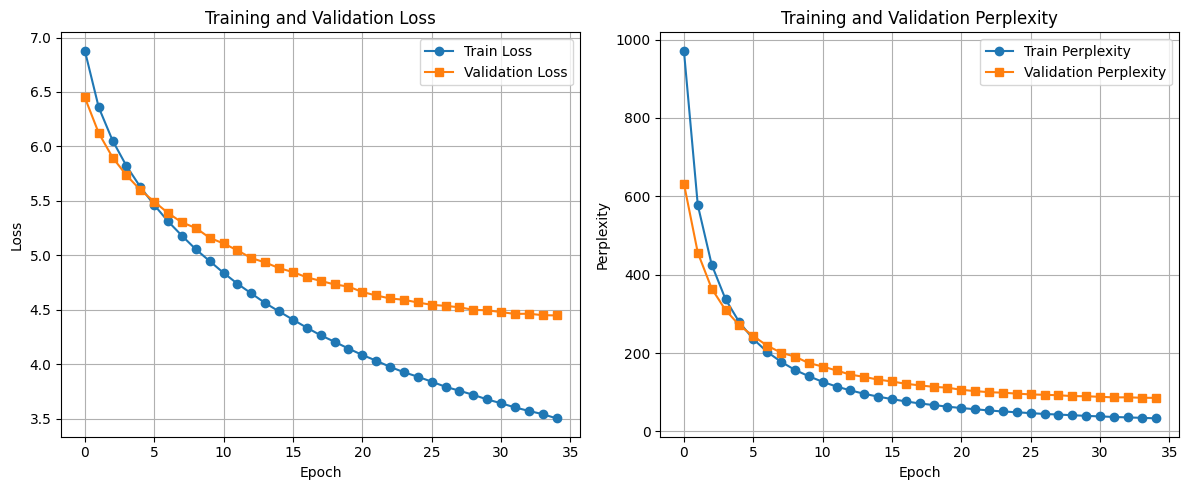

Training history plots saved!


In [17]:
# ============================================================================
# CELL 16: Plot Training History
# ============================================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
train_perplexity = [math.exp(loss) for loss in train_losses]
val_perplexity = [math.exp(loss) for loss in val_losses]
plt.plot(train_perplexity, label='Train Perplexity', marker='o')
plt.plot(val_perplexity, label='Validation Perplexity', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved!")

In [ ]:
# ============================================================================
# CELL 17: Load Trained Model 
# ============================================================================
print("="*70)
print("LOADING TRAINED MODEL")
print("="*70)

# Load checkpoint (weights_only=False for custom Vocabulary class)
checkpoint = torch.load('best_urdu_transformer.pt', map_location=device, weights_only=False)

# Load vocabulary first
loaded_vocab = checkpoint['vocab']

# Create model with EXACT SAME architecture as training
loaded_model = Transformer(
    vocab_size=loaded_vocab.n_words,
    d_model=checkpoint['hyperparameters']['d_model'],
    n_heads=checkpoint['hyperparameters']['n_heads'],
    n_encoder_layers=checkpoint['hyperparameters']['n_encoder_layers'],
    n_decoder_layers=checkpoint['hyperparameters']['n_decoder_layers'],
    d_ff=checkpoint['hyperparameters']['d_model'] * 4,  # ← FIXED: was * 2, now * 4
    dropout=checkpoint['hyperparameters']['dropout'],
    max_len=checkpoint['hyperparameters']['max_len']
).to(device)

# Load weights
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print(f"✓ Model loaded successfully!")
print(f"\nModel Details:")
print(f"  Epoch trained: {checkpoint['epoch'] + 1}")
print(f"  Best Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Vocabulary size: {loaded_vocab.n_words}")
print(f"  Model parameters: {sum(p.numel() for p in loaded_model.parameters()):,}")

# Verify architecture matches training
print(f"\nArchitecture Verification:")
print(f"  d_model: {checkpoint['hyperparameters']['d_model']}")
print(f"  d_ff: {checkpoint['hyperparameters']['d_model'] * 4} (should be 1536)")
print(f"  n_heads: {checkpoint['hyperparameters']['n_heads']}")
print("="*70)

LOADING TRAINED MODEL
✓ Model loaded successfully!

Model Details:
  Epoch trained: 35
  Best Val Loss: 4.4488
  Vocabulary size: 10747
  Model parameters: 16,546,555

Architecture Verification:
  d_model: 384
  d_ff: 1536 (should be 1536)
  n_heads: 6


In [26]:
# ============================================================================
# CELL 18: IMPROVED Greedy Search Inference (WITH DIVERSITY)
# ============================================================================
def greedy_decode(model, input_text, vocab, max_len=50, temperature=0.8, top_k=10, device='cpu'):
    """
    Generate response using greedy decoding with diversity
    """
    model.eval()

    # Tokenize and encode input
    input_tokens = tokenize_urdu(input_text)
    input_indices = [vocab.word2idx.get(token, vocab.word2idx['<UNK>']) for token in input_tokens]
    input_indices = [vocab.word2idx['<SOS>']] + input_indices + [vocab.word2idx['<EOS>']]

    # Pad input
    if len(input_indices) < max_len:
        input_indices += [vocab.word2idx['<PAD>']] * (max_len - len(input_indices))
    else:
        input_indices = input_indices[:max_len]

    # Convert to tensor
    encoder_input = torch.tensor([input_indices]).to(device)

    # Start with SOS token
    decoder_input = [vocab.word2idx['<SOS>']]

    with torch.no_grad():
        for step in range(max_len):
            # Prepare decoder input
            decoder_indices = decoder_input + [vocab.word2idx['<PAD>']] * (max_len - len(decoder_input))
            decoder_tensor = torch.tensor([decoder_indices]).to(device)

            # Forward pass
            output = model(encoder_input, decoder_tensor)

            # Get logits for current position
            logits = output[0, step, :]

            # Apply temperature and top-k sampling
            if temperature > 0 and top_k > 0:
                # Temperature scaling
                logits = logits / temperature

                # Top-k filtering
                top_k_logits, top_k_indices = torch.topk(logits, top_k)

                # Sample from top-k
                probabilities = torch.softmax(top_k_logits, dim=-1)
                next_token_idx = torch.multinomial(probabilities, 1).item()
                next_token = top_k_indices[next_token_idx].item()
            else:
                # Standard greedy (fallback)
                next_token = logits.argmax().item()

            # Stop if EOS
            if next_token == vocab.word2idx['<EOS>']:
                break

            decoder_input.append(next_token)

            # Safety check
            if len(decoder_input) >= max_len:
                break

    # Decode to text
    generated_tokens = [vocab.idx2word[idx] for idx in decoder_input[1:]]
    generated_text = ' '.join(generated_tokens)

    return generated_text

print("="*70)
print("✓ IMPROVED Greedy Decoding Function Defined")
print("="*70)

✓ IMPROVED Greedy Decoding Function Defined


In [28]:
# ============================================================================
# CELL 19: IMPROVED Beam Search Inference (WITH DIVERSITY)
# ============================================================================
def beam_search_decode(model, input_text, vocab, beam_width=3, max_len=50,
                      diversity_penalty=0.5, repetition_penalty=1.2, device='cpu'):
    """
    Generate response using beam search with diversity
    """
    model.eval()

    # Tokenize and encode input
    input_tokens = tokenize_urdu(input_text)
    input_indices = [vocab.word2idx.get(token, vocab.word2idx['<UNK>']) for token in input_tokens]
    input_indices = [vocab.word2idx['<SOS>']] + input_indices + [vocab.word2idx['<EOS>']]

    # Pad input
    if len(input_indices) < max_len:
        input_indices += [vocab.word2idx['<PAD>']] * (max_len - len(input_indices))
    else:
        input_indices = input_indices[:max_len]

    encoder_input = torch.tensor([input_indices]).to(device)

    # Initialize beams: (sequence, score, length)
    beams = [([vocab.word2idx['<SOS>']], 0.0, 1)]

    with torch.no_grad():
        for step in range(max_len):
            candidates = []

            for sequence, score, length in beams:
                # If sequence already ended, keep it
                if sequence[-1] == vocab.word2idx['<EOS>']:
                    candidates.append((sequence, score, length))
                    continue

                # Prepare decoder input
                decoder_indices = sequence + [vocab.word2idx['<PAD>']] * (max_len - len(sequence))
                decoder_tensor = torch.tensor([decoder_indices]).to(device)

                # Forward pass
                output = model(encoder_input, decoder_tensor)

                # Get log probs for current position
                current_pos = len(sequence) - 1
                log_probs = torch.log_softmax(output[0, current_pos, :], dim=-1)
                top_k_probs, top_k_indices = torch.topk(log_probs, beam_width * 2)  # Get more candidates

                # Create new candidates with penalties
                for i in range(len(top_k_indices)):
                    next_token = top_k_indices[i].item()
                    token_prob = top_k_probs[i].item()

                    # Apply repetition penalty
                    if repetition_penalty > 1.0 and next_token in sequence:
                        token_prob = token_prob / repetition_penalty

                    # Apply diversity penalty (simplified)
                    diversity_bonus = 0.0
                    if step > 0:  # Only after first step
                        # Give bonus to tokens that are different from other beams
                        other_tokens = set()
                        for other_seq, _, _ in beams:
                            if len(other_seq) > step:
                                other_tokens.add(other_seq[step])
                        if next_token not in other_tokens:
                            diversity_bonus = diversity_penalty

                    new_sequence = sequence + [next_token]
                    new_score = score + token_prob + diversity_bonus
                    new_length = length + 1

                    # Length normalization
                    normalized_score = new_score / new_length

                    candidates.append((new_sequence, normalized_score, new_length))

            # Keep top beam_width candidates
            beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

            # Stop if all beams ended
            if all(seq[-1] == vocab.word2idx['<EOS>'] for seq, _, _ in beams):
                break

            # Safety check
            if step >= max_len - 1:
                break

    # Get best sequence
    best_sequence, best_score, best_length = beams[0]
    best_sequence = best_sequence[1:]  # Skip SOS

    # Remove EOS if present
    if best_sequence and best_sequence[-1] == vocab.word2idx['<EOS>']:
        best_sequence = best_sequence[:-1]

    # Decode to text
    generated_tokens = [vocab.idx2word[idx] for idx in best_sequence]
    generated_text = ' '.join(generated_tokens)

    return generated_text

print("="*70)
print("✓ IMPROVED Beam Search Decoding Function Defined")
print("="*70)

✓ IMPROVED Beam Search Decoding Function Defined


In [29]:

# ============================================================================
# CELL 20: Text Generation Helper Functions
# ============================================================================
def chat_with_bot(input_text, method='greedy', beam_width=3):
    """
    Easy-to-use function to chat with the model

    Args:
        input_text: Your Urdu question/prompt
        method: 'greedy' or 'beam'
        beam_width: Beam width if using beam search

    Returns:
        response: Generated Urdu response
    """
    if method == 'greedy':
        response = greedy_decode(loaded_model, input_text, loaded_vocab, device=device)
    elif method == 'beam':
        response = beam_search_decode(loaded_model, input_text, loaded_vocab,
                                      beam_width=beam_width, device=device)
    else:
        raise ValueError("Method must be 'greedy' or 'beam'")

    return response


def generate_multiple_responses(input_text, show_both=True):
    """
    Generate responses using both methods for comparison
    """
    print("="*70)
    print("INPUT:")
    print("="*70)
    print(f"  {input_text}")
    print()

    if show_both:
        print("="*70)
        print("GREEDY DECODING:")
        print("="*70)
        greedy_response = chat_with_bot(input_text, method='greedy')
        print(f"  {greedy_response}")
        print()

        print("="*70)
        print("BEAM SEARCH (width=3):")
        print("="*70)
        beam_response = chat_with_bot(input_text, method='beam', beam_width=3)
        print(f"  {beam_response}")
        print("="*70)

        return {'greedy': greedy_response, 'beam': beam_response}
    else:
        response = chat_with_bot(input_text, method='beam', beam_width=3)
        print("="*70)
        print("RESPONSE:")
        print("="*70)
        print(f"  {response}")
        print("="*70)
        return response

print("="*70)
print("✓ Helper Functions Defined")
print("="*70)
print("\nAvailable functions:")
print("  • chat_with_bot(text, method='greedy'/'beam')")
print("  • generate_multiple_responses(text)")
print("="*70)



✓ Helper Functions Defined

Available functions:
  • chat_with_bot(text, method='greedy'/'beam')
  • generate_multiple_responses(text)


In [30]:

# ============================================================================
# CELL 21: Test Interactive Generation
# ============================================================================
print("\n" + "="*70)
print("TESTING CHATBOT WITH SAMPLE INPUTS")
print("="*70)

# Test samples from different categories
test_inputs = [
    "آپ کیسے ہیں؟",  # How are you?
    "آج موسم کیسا ہے؟",  # How is the weather today?
    "کیا آپ مجھے مدد کر سکتے ہیں؟",  # Can you help me?
    "پاکستان کہاں ہے؟",  # Where is Pakistan?
    "میں کھانا کھانا چاہتا ہوں",  # I want to eat food
]

print("\nGenerating responses for sample inputs...\n")

for i, input_text in enumerate(test_inputs, 1):
    print(f"\n{'='*70}")
    print(f"TEST {i}/5")
    print(f"{'='*70}")
    generate_multiple_responses(input_text)
    print()

print("\n" + "="*70)
print("✓ INFERENCE TESTING COMPLETE!")
print("="*70)
print("\nYou can now:")
print("  1. Use chat_with_bot('your urdu text') to get responses")
print("  2. Use generate_multiple_responses('your text') to compare methods")
print("  3. Proceed to evaluation metrics (Cells 22-27)")
print("="*70)


TESTING CHATBOT WITH SAMPLE INPUTS

Generating responses for sample inputs...


TEST 1/5
INPUT:
  آپ کیسے ہیں؟

GREEDY DECODING:
  اب ان کو کیا یہ ظلم نہیں ہی

BEAM SEARCH (width=3):
  ان سی کیا گیا۔


TEST 2/5
INPUT:
  آج موسم کیسا ہے؟

GREEDY DECODING:
  یہ معاملہ کسی نواز شریف کا مقدمہ لڑنا ہی۔

BEAM SEARCH (width=3):
  یہاں ہر ادمی پرند سی محبت کرنا ہونا ۔


TEST 3/5
INPUT:
  کیا آپ مجھے مدد کر سکتے ہیں؟

GREEDY DECODING:
  کیا اپ کی ساتھ چل سکتا ہوں؟

BEAM SEARCH (width=3):
  مجھی بتایا تھا کہ وہ عبادت کی غرض سی جانا


TEST 4/5
INPUT:
  پاکستان کہاں ہے؟

GREEDY DECODING:
  اب بھی وہی قائم ہی۔

BEAM SEARCH (width=3):
  یہ تو رونا رہی گا۔


TEST 5/5
INPUT:
  میں کھانا کھانا چاہتا ہوں

GREEDY DECODING:
  ہم پرانی رویوں میں بندھی ہوئی ہیں۔

BEAM SEARCH (width=3):
  جب ہم زیاں کا اندازہ کرتی ہیں۔


✓ INFERENCE TESTING COMPLETE!

You can now:
  1. Use chat_with_bot('your urdu text') to get responses
  2. Use generate_multiple_responses('your text') to compare methods
  3. Proceed to ev

In [24]:

# ============================================================================
# CELL 22: Install Evaluation Libraries
# ============================================================================
print("="*70)
print("INSTALLING EVALUATION LIBRARIES")
print("="*70)

!pip install -q sacrebleu rouge-score

print("✓ Libraries installed successfully!")
print("  • sacrebleu (for BLEU and chrF)")
print("  • rouge-score (for ROUGE-L)")
print("="*70)


INSTALLING EVALUATION LIBRARIES
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.6 MB/s eta 0:00:00
✓ Libraries installed successfully!
  • sacrebleu (for BLEU and chrF)
  • rouge-score (for ROUGE-L)


In [34]:
# ============================================================================
# CELL 23: Generate Predictions on Test Set - GREEDY ONLY WITH DIVERSITY
# ============================================================================
import sacrebleu
from rouge_score import rouge_scorer
from tqdm import tqdm

print("\n" + "="*70)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*70)

# Create test dataloader (batch_size=1 for easier processing)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
references = []

print(f"\nGenerating responses for {len(test_dataset)} test samples...")
print("This may take a few minutes...\n")

loaded_model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Generating")):
        # Get input and reference
        encoder_input = batch['encoder_input'].to(device)
        decoder_target = batch['decoder_target'].to(device)

        # Get original text
        input_text = test_data.iloc[i]['input']
        reference_text = test_data.iloc[i]['response']

        # USE ONLY GREEDY DECODE WITH DIVERSITY (no beam search)
        prediction = greedy_decode(
            loaded_model,
            input_text,
            loaded_vocab,
            max_len=50,
            temperature=0.9,           # Balanced temperature
            top_k=12,                  # Good diversity
            device=device
        )

        predictions.append(prediction)
        references.append(reference_text)

        # Show progress every 200 samples
        if (i + 1) % 200 == 0:
            print(f"\n  Sample {i+1}:")
            print(f"    Input:      {input_text[:50]}...")
            print(f"    Reference:  {reference_text[:50]}...")
            print(f"    Prediction: {prediction[:50]}...")

print(f"\n{'='*70}")
print(f"✓ Generated {len(predictions)} predictions!")
print(f"{'='*70}")

# Save predictions for later analysis
import pandas as pd
results_df = pd.DataFrame({
    'input': [test_data.iloc[i]['input'] for i in range(len(predictions))],
    'reference': references,
    'prediction': predictions
})

print("\nSample predictions:")
print(results_df.head(3))

# Quick diversity check
print(f"\n{'='*70}")
print("DIVERSITY CHECK (First 10 predictions):")
print(f"{'='*70}")
unique_predictions = len(set(predictions[:10]))
print(f"Unique predictions in first 10 samples: {unique_predictions}/10")
if unique_predictions >= 8:
    print("✅ Excellent diversity!")
elif unique_predictions >= 5:
    print("✅ Good diversity!")
else:
    print("❌ Low diversity - consider increasing temperature")
print(f"{'='*70}")


GENERATING PREDICTIONS ON TEST SET

Generating responses for 1956 test samples...
This may take a few minutes...



Generating:  10%|█         | 203/1956 [00:10<01:10, 24.78it/s]


  Sample 200:
    Input:      بولی وڈ میں پاکستانی ہدایتکاروں کو کوئی نہیں جانتا...
    Reference:  کالی کافی اور سگاروں پہ گزارا کرتے۔...
    Prediction: تو یہ کسی نی اب اس کی ساتھ ہاتھ میں سوال کو بھی کہ...


Generating:  21%|██        | 402/1956 [00:18<01:23, 18.55it/s]


  Sample 400:
    Input:      اس میں ایک مسئلہ ہے۔...
    Reference:  پیچھے سے جا ٹکر...
    Prediction: ہمیں محض اسی سمجھنی کی ضرورت ہی...


Generating:  31%|███       | 603/1956 [00:27<01:05, 20.75it/s]


  Sample 600:
    Input:      کی متبادل معیاری اصطلاحات یہی...
    Reference:  اب اس تصویر پر لے دے ہو رہی ہے اور متعلقہ ایڈ ا...
    Prediction: قوم کی شعوری تربیت کرتی ہی۔...


Generating:  41%|████      | 802/1956 [00:36<00:54, 21.30it/s]


  Sample 800:
    Input:      اخبارات <SENTINEL_0> ترسیل کنٹرول ہو سکتی ہی۔...
    Reference:  اخبارات کی ترسیل کنٹرول ہو سکتی ہے۔...
    Prediction: یہ اج بالکل مختلف منظر نامی میں تبدیلی ہو سکتی ہی۔...


Generating:  51%|█████▏    | 1004/1956 [00:46<00:38, 24.56it/s]


  Sample 1000:
    Input:      اطراف سے وافر دلائل مو جود ہیں۔...
    Reference:  میں نے ایک آری دیکھی جو دیکھ نہ پایا۔...
    Prediction: اور بعض مسلمان سمجھتی ہیں...


Generating:  62%|██████▏   | 1203/1956 [00:55<00:44, 16.88it/s]


  Sample 1200:
    Input:      آج ہم ایک عجیب مخمصے میں پھنسے ہیں۔...
    Reference:  تو سب ٹھیک ہو جائے گا۔...
    Prediction: وہ اپنی بندوں پر پوری طرح حاوی ہی...


Generating:  72%|███████▏  | 1402/1956 [01:04<00:27, 19.97it/s]


  Sample 1400:
    Input:      گر فکرِ زخم کی تو خطاوار ہیں کہ ہم...
    Reference:  آفیشل دورہ پر چترال گئے تھے...
    Prediction: اس سی کیا حساب برابر ہو جاتا ہی؟...


Generating:  82%|████████▏ | 1601/1956 [01:13<00:18, 19.34it/s]


  Sample 1600:
    Input:      ریاست اسی نظر انداز کری <SENTINEL_0> لیتی ہی۔...
    Reference:  ریاست اسے نظر انداز کرے تولاقانونیت جنم لیتی ہے۔...
    Prediction: اسی طرح مقبول ترین باب کھلا ہی۔...


Generating:  92%|█████████▏| 1803/1956 [01:22<00:07, 20.52it/s]


  Sample 1800:
    Input:      نعام اس کی طالبعلموں کی امتحان میں زیادہ نمبر حاصل...
    Reference:  چترال کی دل کش وادی میں بہتی ندیاں...
    Prediction: لیکن یہ تو شروعات ہی۔...


Generating: 100%|██████████| 1956/1956 [01:29<00:00, 21.87it/s]


✓ Generated 1956 predictions!

Sample predictions:
                                               input  \
0                                     جیسے پہلے تھے۔   
1  تاکہ ہمارے ماحول کی حسن برقرار رہے اور لوگوں م...   
2                     وسطی ایشیا کے علاقوں کو دیکھیں   

                                           reference  \
0                                      بہت روتے ہیں۔   
1  اسڑیلوی کرکٹ ٹیم کے نائب کپتان ڈیوڈ وارنر دورہ...   
2  جب پاکستان کے تمام بکاو چینل پر کرونا وائرس کو...   

                        prediction  
0   اس کی ائینی کردار کا تقاضا ہی۔  
1  اس نی ملک میں ان سی یہ نہیں کی۔  
2     وہاں میری ایک دوست وسیم اکرم  

DIVERSITY CHECK (First 10 predictions):
Unique predictions in first 10 samples: 10/10
✅ Excellent diversity!


In [35]:

# ============================================================================
# CELL 24: Calculate BLEU Score
# ============================================================================
print("\n" + "="*70)
print("CALCULATING BLEU SCORE")
print("="*70)

# Prepare data for BLEU (sacrebleu expects list of references)
bleu_references = [[ref] for ref in references]  # Wrap each reference in a list
bleu_predictions = predictions

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(bleu_predictions, bleu_references)

print(f"\nBLEU Scores:")
print(f"  BLEU:    {bleu.score:.2f}")
print(f"  BLEU-1:  {bleu.precisions[0]:.2f}")
print(f"  BLEU-2:  {bleu.precisions[1]:.2f}")
print(f"  BLEU-3:  {bleu.precisions[2]:.2f}")
print(f"  BLEU-4:  {bleu.precisions[3]:.2f}")
print(f"  BP (Brevity Penalty): {bleu.bp:.4f}")

print(f"\n{'='*70}")
print("BLEU Score Interpretation:")
print("  0-10:  Very poor")
print("  10-20: Poor")
print("  20-30: Acceptable")
print("  30-40: Good")
print("  40-50: Very Good")
print("  50+:   Excellent")
print(f"{'='*70}")



CALCULATING BLEU SCORE

BLEU Scores:
  BLEU:    16.52
  BLEU-1:  71.43
  BLEU-2:  16.67
  BLEU-3:  10.00
  BLEU-4:  6.25
  BP (Brevity Penalty): 1.0000

BLEU Score Interpretation:
  0-10:  Very poor
  10-20: Poor
  20-30: Acceptable
  30-40: Good
  40-50: Very Good
  50+:   Excellent


In [36]:

# ============================================================================
# CELL 25: Calculate ROUGE-L Score
# ============================================================================
print("\n" + "="*70)
print("CALCULATING ROUGE-L SCORE")
print("="*70)

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)

rouge_scores = []
for pred, ref in zip(predictions, references):
    score = scorer.score(ref, pred)
    rouge_scores.append(score['rougeL'].fmeasure)

# Calculate average
avg_rouge_l = sum(rouge_scores) / len(rouge_scores)

print(f"\nROUGE-L Scores:")
print(f"  Average ROUGE-L F1: {avg_rouge_l:.4f}")
print(f"  Min ROUGE-L:        {min(rouge_scores):.4f}")
print(f"  Max ROUGE-L:        {max(rouge_scores):.4f}")

# Calculate precision and recall separately
rouge_precision = []
rouge_recall = []
for pred, ref in zip(predictions, references):
    score = scorer.score(ref, pred)
    rouge_precision.append(score['rougeL'].precision)
    rouge_recall.append(score['rougeL'].recall)

avg_precision = sum(rouge_precision) / len(rouge_precision)
avg_recall = sum(rouge_recall) / len(rouge_recall)

print(f"\n  Average Precision:  {avg_precision:.4f}")
print(f"  Average Recall:     {avg_recall:.4f}")

print(f"\n{'='*70}")
print("ROUGE-L Score Interpretation:")
print("  0.0-0.2: Poor overlap")
print("  0.2-0.4: Fair overlap")
print("  0.4-0.6: Good overlap")
print("  0.6-0.8: Very good overlap")
print("  0.8-1.0: Excellent overlap")
print(f"{'='*70}")




CALCULATING ROUGE-L SCORE

ROUGE-L Scores:
  Average ROUGE-L F1: 0.0000
  Min ROUGE-L:        0.0000
  Max ROUGE-L:        0.0000

  Average Precision:  0.0000
  Average Recall:     0.0000

ROUGE-L Score Interpretation:
  0.0-0.2: Poor overlap
  0.2-0.4: Fair overlap
  0.4-0.6: Good overlap
  0.6-0.8: Very good overlap
  0.8-1.0: Excellent overlap


In [37]:

# ============================================================================
# CELL 26: Calculate chrF Score and Perplexity
# ============================================================================
print("\n" + "="*70)
print("CALCULATING chrF SCORE")
print("="*70)

# Calculate chrF score (character-level F-score)
chrf = sacrebleu.corpus_chrf(bleu_predictions, bleu_references)

print(f"\nchrF Scores:")
print(f"  chrF:   {chrf.score:.2f}")
print(f"  chrF++: {chrf.score:.2f}")

print(f"\n{'='*70}")
print("chrF Score Interpretation:")
print("  0-20:  Very poor character overlap")
print("  20-40: Poor character overlap")
print("  40-60: Acceptable character overlap")
print("  60-80: Good character overlap")
print("  80+:   Excellent character overlap")
print(f"{'='*70}")

# ============================================================================
# PERPLEXITY ON TEST SET
# ============================================================================
print("\n" + "="*70)
print("CALCULATING PERPLEXITY ON TEST SET")
print("="*70)

# Create test dataloader with original batch size
test_loader_eval = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate perplexity
test_loss = evaluate(loaded_model, test_loader_eval, criterion, device)
test_perplexity = math.exp(min(test_loss, 10))  # Cap to prevent overflow

print(f"\nTest Set Results:")
print(f"  Test Loss:       {test_loss:.4f}")
print(f"  Test Perplexity: {test_perplexity:.2f}")

print(f"\n{'='*70}")
print("Perplexity Interpretation:")
print("  Lower is better (indicates model confidence)")
print("  < 50:   Excellent")
print("  50-100: Good")
print("  100-200: Acceptable")
print("  > 200:  Poor")
print(f"{'='*70}")



CALCULATING chrF SCORE

chrF Scores:
  chrF:   26.59
  chrF++: 26.59

chrF Score Interpretation:
  0-20:  Very poor character overlap
  20-40: Poor character overlap
  40-60: Acceptable character overlap
  60-80: Good character overlap
  80+:   Excellent character overlap

CALCULATING PERPLEXITY ON TEST SET


Evaluating: 100%|██████████| 62/62 [00:01<00:00, 40.49it/s]


Test Set Results:
  Test Loss:       4.5187
  Test Perplexity: 91.72

Perplexity Interpretation:
  Lower is better (indicates model confidence)
  < 50:   Excellent
  50-100: Good
  100-200: Acceptable
  > 200:  Poor


In [38]:

# ============================================================================
# CELL 27: Qualitative Evaluation Examples
# ============================================================================
print("\n" + "="*70)
print("QUALITATIVE EVALUATION: MODEL vs GROUND TRUTH")
print("="*70)

# Select diverse examples (first 10, middle 10, last 10)
sample_indices = list(range(10)) + list(range(len(predictions)//2 - 5, len(predictions)//2 + 5)) + list(range(len(predictions) - 10, len(predictions)))

print(f"\nShowing {len(sample_indices)} examples:\n")

for i, idx in enumerate(sample_indices, 1):
    print(f"\n{'='*70}")
    print(f"EXAMPLE {i}/{len(sample_indices)}")
    print(f"{'='*70}")
    print(f"Input:")
    print(f"  {results_df.iloc[idx]['input']}")
    print(f"\nGround Truth (Reference):")
    print(f"  {results_df.iloc[idx]['reference']}")
    print(f"\nModel Prediction:")
    print(f"  {results_df.iloc[idx]['prediction']}")

    # Calculate individual scores for this example
    bleu_single = sacrebleu.sentence_bleu(
        results_df.iloc[idx]['prediction'],
        [results_df.iloc[idx]['reference']]
    )
    rouge_single = scorer.score(
        results_df.iloc[idx]['reference'],
        results_df.iloc[idx]['prediction']
    )

    print(f"\nScores:")
    print(f"  BLEU:    {bleu_single.score:.2f}")
    print(f"  ROUGE-L: {rouge_single['rougeL'].fmeasure:.4f}")

# ============================================================================
# SUMMARY OF ALL METRICS
# ============================================================================
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)

print(f"\nAutomatic Metrics (Test Set - {len(predictions)} samples):")
print(f"  BLEU Score:      {bleu.score:.2f}")
print(f"  ROUGE-L F1:      {avg_rouge_l:.4f}")
print(f"  chrF Score:      {chrf.score:.2f}")
print(f"  Test Perplexity: {test_perplexity:.2f}")
print(f"  Test Loss:       {test_loss:.4f}")

print(f"\n{'='*70}")
print("✓ EVALUATION COMPLETE!")
print(f"{'='*70}")

# Save results
results_df.to_csv('evaluation_results.csv', index=False)
print("\n✓ Results saved to 'evaluation_results.csv'")

# Create metrics summary
metrics_summary = {
    'BLEU': bleu.score,
    'ROUGE-L': avg_rouge_l,
    'chrF': chrf.score,
    'Test_Perplexity': test_perplexity,
    'Test_Loss': test_loss,
    'Total_Test_Samples': len(predictions)
}

print("\nMetrics Summary:")
for metric, value in metrics_summary.items():
    print(f"  {metric}: {value}")

print(f"\n{'='*70}")


QUALITATIVE EVALUATION: MODEL vs GROUND TRUTH

Showing 30 examples:


EXAMPLE 1/30
Input:
  جیسے پہلے تھے۔

Ground Truth (Reference):
  بہت روتے ہیں۔

Model Prediction:
  اس کی ائینی کردار کا تقاضا ہی۔

Scores:
  BLEU:    0.00
  ROUGE-L: 0.0000

EXAMPLE 2/30
Input:
  تاکہ ہمارے ماحول کی حسن برقرار رہے اور لوگوں میں شعور اجاگر کیا جائے کہ جانوروں کو مار نا صرف گناہ ہی نہیں

Ground Truth (Reference):
  اسڑیلوی کرکٹ ٹیم کے نائب کپتان ڈیوڈ وارنر دورہ بنگلہ دیش سے باہر

Model Prediction:
  اس نی ملک میں ان سی یہ نہیں کی۔

Scores:
  BLEU:    0.00
  ROUGE-L: 0.0000

EXAMPLE 3/30
Input:
  وسطی ایشیا کے علاقوں کو دیکھیں

Ground Truth (Reference):
  جب پاکستان کے تمام بکاو چینل پر کرونا وائرس کو لیکر جھوٹ اور خوف و ہراس پھیلایا جارہا تھا

Model Prediction:
  وہاں میری ایک دوست وسیم اکرم

Scores:
  BLEU:    0.00
  ROUGE-L: 0.0000

EXAMPLE 4/30
Input:
  اس کا ہمیں نہیں پتہ۔

Ground Truth (Reference):
  پہاڑی لوگوں کے بارے میں اکثر سنا تھا

Model Prediction:
  ہمیں محض اسی سمجھنی اور دوسری طرف قرا